In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
# Use English stemmer.
stemmer = SnowballStemmer("english")
from sklearn.metrics import log_loss
# log_loss(y_test, preds)
import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_train.shape

(404290, 6)

In [5]:
df_train['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

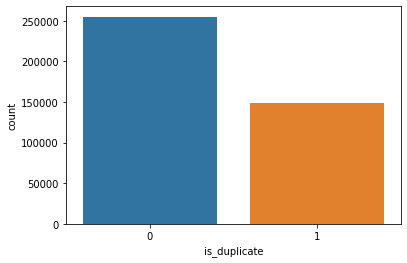

In [6]:
sns.countplot(x='is_duplicate', data=df_train)

In [7]:
final_list = list(set(df_train['qid1']) | set(df_train['qid1']))

In [8]:
print('Total number of unique questions : ', len(final_list))

Total number of unique questions :  290654


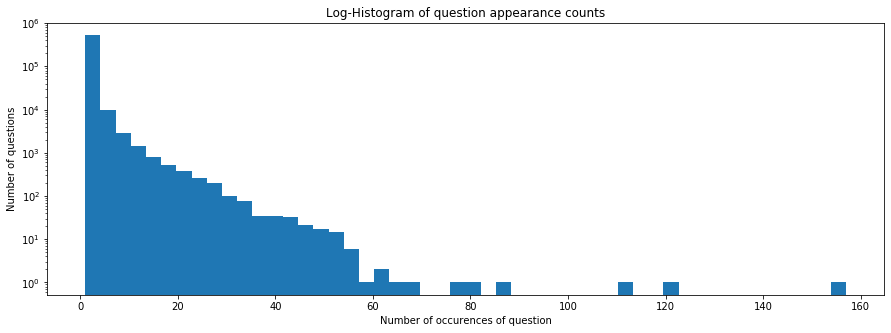

In [9]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())

plt.figure(figsize=(15, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [10]:
 df_train['question1'].isna().sum(), df_train['question2'].isna().sum()

(1, 2)

In [11]:
df_train.shape[0] - df_train.dropna(how='any').shape[0]

3

In [12]:
df_train = df_train.dropna(how='any')

In [14]:
df_train['question1'] = df_train['question1'].str.lower()
df_train['question2'] = df_train['question2'].str.lower()

In [15]:
df_train[:5]['question1']

0    what is the step by step guide to invest in sh...
1    what is the story of kohinoor (koh-i-noor) dia...
2    how can i increase the speed of my internet co...
3    why am i mentally very lonely? how can i solve...
4    which one dissolve in water quikly sugar, salt...
Name: question1, dtype: object

In [16]:
import string
exclude = set(string.punctuation)

In [17]:
df_train['qmark_count1'] = df_train['question1'].apply(lambda x: len([item for item in x if item == '?']))

In [18]:
df_train['qmark_count2'] = df_train['question2'].apply(lambda x: len([item for item in x if item == '?']))

In [19]:
df_train['question1'] = df_train['question1'].apply(lambda x: ''.join(item for item in x if item not in exclude))
df_train['question2'] = df_train['question2'].apply(lambda x: ''.join(item for item in x if item not in exclude))

In [20]:
df_train[:5]['question1']

0    what is the step by step guide to invest in sh...
1       what is the story of kohinoor kohinoor diamond
2    how can i increase the speed of my internet co...
3     why am i mentally very lonely how can i solve it
4    which one dissolve in water quikly sugar salt ...
Name: question1, dtype: object

In [21]:
df_train['question1'] = df_train['question1'].str.split()
df_train['question2'] = df_train['question2'].str.split()

In [22]:
x = df_train[(df_train['question1'].str.len() == 0) | (df_train['question2'].str.len() == 0)]
x.shape

(14, 8)

In [23]:
df_train = df_train[(df_train['question1'].str.len() != 0) & (df_train['question2'].str.len() != 0)]

In [24]:
common_words = []
for a,b in zip(df_train.question1, df_train.question2): 
    t = len(list(set(a) & set(b)))
    common_words.append(t)

In [25]:
df_train['common_words'] = common_words

In [26]:
df_train['question1'] = df_train['question1'].apply(lambda x: [item for item in x if item not in stop])
df_train['question2'] = df_train['question2'].apply(lambda x: [item for item in x if item not in stop])

In [27]:
df_train[:5]['question1']

0    [step, step, guide, invest, share, market, india]
1                 [story, kohinoor, kohinoor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
Name: question1, dtype: object

In [28]:
df_train['q1_s'] = df_train['question1'].apply(lambda x: [stemmer.stem(y) for y in x])
df_train['q2_s'] = df_train['question2'].apply(lambda x: [stemmer.stem(y) for y in x])

In [29]:
df_train[:5]['q1_s']

0     [step, step, guid, invest, share, market, india]
1                 [stori, kohinoor, kohinoor, diamond]
2        [increas, speed, internet, connect, use, vpn]
3                                 [mental, lone, solv]
4    [one, dissolv, water, quik, sugar, salt, metha...
Name: q1_s, dtype: object

In [30]:
df_train[:5]['q2_s']

0            [step, step, guid, invest, share, market]
1    [would, happen, indian, govern, stole, kohinoo...
2                [internet, speed, increas, hack, dns]
3           [find, remaind, math2324math, divid, 2423]
4                   [fish, would, surviv, salt, water]
Name: q2_s, dtype: object

In [31]:
df_train[:5]['question1']

0    [step, step, guide, invest, share, market, india]
1                 [story, kohinoor, kohinoor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
Name: question1, dtype: object

In [32]:
df_train.to_pickle("dataset.pkl")

In [33]:
x = df_train[(df_train['q1_s'].str.len() == 0) | (df_train['q2_s'].str.len() == 0)]
x.shape

(106, 11)

In [34]:
x['is_duplicate'].value_counts()

0    102
1      4
Name: is_duplicate, dtype: int64

In [35]:
df_train = df_train[(df_train['q1_s'].str.len() != 0) & (df_train['q2_s'].str.len() != 0)]

In [36]:
match_frac = []
for a,b in zip(df_train.q1_s, df_train.q2_s): 
    t = len(list(set(a) & set(b)))/(len(set(a)) + len(set(b)))
    match_frac.append(t)

In [37]:
df_train['match_frac'] = match_frac

In [38]:
lengths = []
for a,b in zip(df_train.q1_s, df_train.q2_s): 
    t = abs(len(a) - len(b))
    lengths.append(t)

In [39]:
df_train['len_diff'] = lengths

/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'word_match_share')

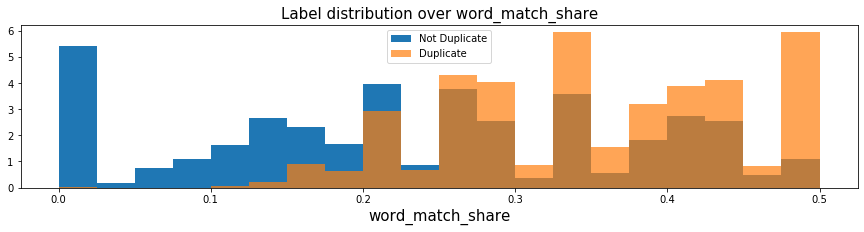

In [40]:
plt.figure(figsize=(15, 3))
plt.hist(df_train[df_train['is_duplicate'] == 0]['match_frac'], bins=20, normed=True, label='Not Duplicate')
plt.hist(df_train[df_train['is_duplicate'] == 1]['match_frac'], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [41]:
# df_train.to_pickle("dataset.pkl")

In [42]:
sentences = list(df_train['q1_s']) + list(df_train['q2_s'])

embed_size = 200

model = Word2Vec(sentences, size=embed_size, window=3, min_count=1, workers=4)

In [43]:
model.wv.most_similar(positive=['water'])

[('salt', 0.6512497663497925),
 ('oxygen', 0.6339125633239746),
 ('nanosilv', 0.6198338866233826),
 ('drinkabl', 0.6109119653701782),
 ('heat', 0.5966075658798218),
 ('epsom', 0.5964449644088745),
 ('co2', 0.5950143337249756),
 ('evapor', 0.5943679213523865),
 ('nitrogen', 0.5939146280288696),
 ('liquid', 0.5888506174087524)]

In [45]:
with open('word2vec.pkl', 'wb') as fid:
    pickle.dump(model, fid)    

In [48]:
df_train.to_pickle('dataset.pkl')

In [51]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [53]:
import pickle

In [54]:
# load it again
with open('word2vec.pkl', 'rb') as fid:
    model = pickle.load(fid)

In [58]:
df_train = pd.read_pickle('dataset.pkl')

In [61]:
global vecs
vecs = []
global vecs2
vecs2 = []
embed_size = 200
def cosine_sim_ques(q1, q2):
    global vecs
    global vecs2
    
    for i in list(q1.values):
        vec = np.zeros(embed_size,)
        for x in i:
            vec = vec + model[x]
        vec = vec/len(i)
        vecs.append(vec)

    vecs = np.array(vecs)
    vecs[np.isnan(vecs)] = 0

    for i in list(q2):
        vec = np.zeros(embed_size,)
        for x in i:
            vec = vec + model[x]
        vec = vec/len(i)
        vecs2.append(vec)

    vecs2 = np.array(vecs2)
    vecs2[np.isnan(vecs2)] = 0    
    c = []
    for i in range(vecs.shape[0]):
        result = 1 - spatial.distance.cosine(vecs[i], vecs2[i])
        c.append(result)
    print(len(c))
    return c

In [62]:
df_train['cosine_sim_q1_q2'] = cosine_sim_ques(df_train['q1_s'], df_train['q2_s'])

/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/home/prerit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


404167


In [63]:
vecs.shape, vecs2.shape

((404167, 200), (404167, 200))

In [64]:
vecs = pd.DataFrame(vecs)
vecs2 = pd.DataFrame(vecs2)

In [65]:
df_train.shape

(404167, 14)

In [66]:
vecs.reset_index(drop=True, inplace=True)

In [67]:
vecs2.reset_index(drop=True, inplace=True)

In [68]:
df_train.reset_index(drop=True, inplace=True)

In [69]:
df_train = pd.concat((df_train, vecs), axis=1)

In [70]:
df_train.reset_index(drop=True, inplace=True)

In [71]:
df_train = pd.concat((df_train, vecs2), axis=1)

In [72]:
df_train.shape

(404167, 414)

In [73]:
# df_train.to_pickle("data_vec.pkl")

In [74]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
df_train = pd.read_pickle("data_vec.pkl")

In [3]:
df_train.shape

(404167, 414)

In [4]:

# X = model[model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# pyplot.scatter(result[:, 0], result[:, 1])
# words = list(model.wv.vocab)
# for i, word in enumerate(words):
#     pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

In [5]:
df_train.columns

Index([          'id',         'qid1',         'qid2',    'question1',
          'question2', 'is_duplicate', 'qmark_count1', 'qmark_count2',
       'common_words',         'q1_s',
       ...
                  190,            191,            192,            193,
                  194,            195,            196,            197,
                  198,            199],
      dtype='object', length=414)

In [6]:
df_train.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'q1_s', 'q2_s'], axis=1, inplace=True)

In [7]:
df_train.columns

Index([    'is_duplicate',     'qmark_count1',     'qmark_count2',
           'common_words',       'match_frac',         'len_diff',
       'cosine_sim_q1_q2',                  0,                  1,
                        2,
       ...
                      190,                191,                192,
                      193,                194,                195,
                      196,                197,                198,
                      199],
      dtype='object', length=407)

In [8]:
Y = df_train['is_duplicate']

In [9]:
df_train.drop(['is_duplicate'], inplace=True, axis=1)

In [10]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [11]:
# X = df_train[['common_words', 'match_frac', 'len_diff', 'cosine_sim_q1_q2']]

In [12]:
df_train = normalize(df_train)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_train, Y, test_size=0.20, random_state=42)

In [14]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

Using TensorFlow backend.


In [15]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [16]:
y_resampled.value_counts()

1    203978
0    203978
Name: is_duplicate, dtype: int64

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
def conf_matrix(true, preds):
    cm = confusion_matrix(y_test, preds, normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

In [20]:
clf = LogisticRegression()
# clf = RandomForestClassifier()
# clf = BernoulliNB()
# clf = GradientBoostingClassifier()
# clf = KNeighborsClassifier()

In [21]:
clf.fit(X_resampled, y_resampled)

/home/prerit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
preds = clf.predict(X_test)

In [23]:
print("Accuracy : ", accuracy_score(y_test, preds))
print("Precision : ", precision_score(y_test, preds))
print("Recall : ", recall_score(y_test, preds))

Accuracy :  0.7247445381893758
Precision :  0.5977172913900521
Recall :  0.7828049759229535


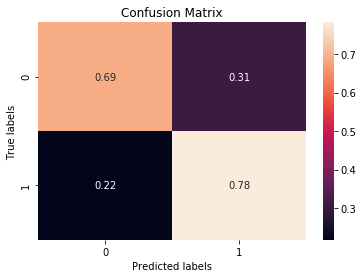

In [24]:
conf_matrix(y_test, preds)

In [27]:
# clf = LogisticRegression()
# clf = RandomForestClassifier()
# clf = BernoulliNB()
# clf = GradientBoostingClassifier()
clf = KNeighborsClassifier()

In [28]:
clf.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
preds = clf.predict(X_test)

In [ ]:
print("Accuracy : ", accuracy_score(y_test, preds))
print("Precision : ", precision_score(y_test, preds))
print("Recall : ", recall_score(y_test, preds))

conf_matrix(y_test, preds)

In [ ]:
clf = LogisticRegression(penalty='l1', solver='liblinear')
# clf = RandomForestClassifier()
# clf = BernoulliNB()
# clf = GradientBoostingClassifier()
# clf = KNeighborsClassifier()

In [ ]:
clf.fit(X_resampled, y_resampled)

In [ ]:
preds = clf.predict_proba(X_test)

In [ ]:
print("Accuracy : ", accuracy_score(y_test, preds))
print("Precision : ", precision_score(y_test, preds))
print("Recall : ", recall_score(y_test, preds))
conf_matrix(y_test, preds)

In [148]:
print("Accuracy : ", accuracy_score(y_test, preds))
print("Precision : ", precision_score(y_test, preds))
print("Recall : ", recall_score(y_test, preds))

Accuracy :  0.7247445381893758
Precision :  0.5977172913900521
Recall :  0.7828049759229535


In [ ]:
conf_matrix(y_test, preds)

In [151]:
y_test.value_counts()

0    50930
1    29904
Name: is_duplicate, dtype: int64

In [152]:
# clf = LogisticRegression()
# clf = RandomForestClassifier()
# clf = GradientBoostingClassifier()
clf = KNeighborsClassifier(n_neighbors=100)

In [153]:
clf.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [ ]:
preds = clf.predict(X_test)

In [ ]:
print("Accuracy : ", accuracy_score(y_test, preds))
print("Precision : ", precision_score(y_test, preds))
print("Recall : ", recall_score(y_test, preds))

In [114]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors':[1, 2, 3, 4, 5, 10, 15, 20]}
clf = KNeighborsClassifier()
clf = GridSearchCV(clf, parameters, scoring=['accuracy', 'recall', 'precision'], refit=False)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([2.00262222, 2.37670498, 2.13024106, 2.35283451, 2.31312089,
        2.55494242, 5.86552329, 5.84380341]),
 'std_fit_time': array([0.41682626, 0.36692263, 0.45697094, 0.3997228 , 0.40841784,
        0.18427039, 0.14126547, 0.11081506]),
 'mean_score_time': array([ 3.23539591,  3.41212511,  3.4480051 ,  3.548388  ,  3.61661472,
         4.0791986 ,  9.9172349 , 10.07303529]),
 'std_score_time': array([0.09841956, 0.04381591, 0.06429227, 0.10886299, 0.14272064,
        0.70484057, 0.17583344, 0.0310188 ]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 10, 15, 20],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20}],
 'split0_test_accuracy': array([0.67960529, 0.68753729, 0.69050634, 0.69466882

In [44]:
cm = confusion_matrix(true, preds, normalize='true')

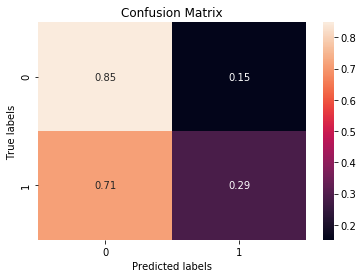

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

### try using lstm, gru, fasttext embedding